# Identify population-enriched genes, plot heatmap

### Import scanpy

In [1]:
import scanpy as sc
import scanpy.external as sce
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [2]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.9.19


In [3]:
import warnings
warnings.filterwarnings( "ignore")

In [4]:
import matplotlib as mpl
mpl.rc('font',family='Arial')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Load data 


In [22]:
adata = sc.read_h5ad('AML/data/AML_prec_only_206_2167x2000_250123_12h07.h5ad')    

In [23]:
# overwrite obs with the most recent version
filename = 'backups/AML_prec_only_206_clust__obs_info_2167x68_250123_16h50.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)
adata.obs = obs

In [24]:

adata.X.sum(axis=1)

matrix([[ 459.4988  ],
        [ 337.34085 ],
        [-479.11826 ],
        ...,
        [-292.71057 ],
        [ 257.36533 ],
        [ -41.697548]], dtype=float32)

In [25]:
adata_raw = sc.read_h5ad('AML/data/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad')

In [26]:
adata_raw.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000286448', 'ENSG00000236601',
       ...
       'ENSG00000275249', 'ENSG00000274792', 'ENSG00000274175',
       'ENSG00000275869', 'ENSG00000273554', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=37733)

In [27]:
adata.var_names_make_unique(join='_')

In [28]:
adata_raw.obs['unique_id'] = adata_raw.obs['barcode'].astype(str)+'_' + adata_raw.obs['library'].astype(str)

In [29]:
bdata = adata_raw[adata.obs.index, :].copy()

In [30]:
bdata.obsm = adata.obsm
bdata.uns = adata.uns
bdata.obsp = adata.obsp
bdata.obs = adata.obs

In [32]:
bdata.X = adata_raw[adata.obs.index, :].layers['counts']

In [33]:
bdata.X.sum(axis=1)

matrix([[9507.],
        [6196.],
        [ 607.],
        ...,
        [2547.],
        [5027.],
        [1663.]], dtype=float32)

### Scale (normalize) data

In [34]:
adata = bdata

In [35]:
adata.X.sum(axis=1)

matrix([[9507.],
        [6196.],
        [ 607.],
        ...,
        [2547.],
        [5027.],
        [1663.]], dtype=float32)

In [36]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[9507.]
 [6196.]
 [ 607.]
 [ 521.]
 [2938.]]

[[10000.   ]
 [10000.001]
 [10000.   ]
 [10000.001]
 [ 9999.999]]


# Get enriched genes

In [37]:
#taking all cells

cmask = np.repeat(True,adata.shape[0])
print(cmask.sum())

2167


In [38]:
for i in adata.obs:
    if i.startswith('louv'):
        print (i)

louvain_resolution_0.5
louvain_resolution_1.0
louvain_resolution_1.5
louvain_resolution_1.7
louvain_resolution_1.8
louvain_resolution_2.0
louvain_resolution_2.5
louvain_resolution_3.0
louvain_resolution_0.1
louvain_resolution_0.2
louvain_resolution_0.3


In [39]:
# get centroids
thelabel = 'louvain_resolution_0.5'
centroids = rz.centroids(thelabel,adata[cmask])

In [40]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove very low abundance genes:
min_counts = 10
min_cells = 10

In [41]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

6281 genes passing abundance filter


In [42]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups/AML_precursors_cluster_vs_rest_MWU_result_dict_%s%s'%(rz.now(), thelabel)
print(fname)
rz.save_stuff(mwu_dict,fname)

1000
2000
3000
4000
5000
6000
1/8
1 done 2167
1000
2000
3000
4000
5000
6000
2/8
0 done 2167
1000
2000
3000
4000
5000
6000
3/8
4 done 2167
1000
2000
3000
4000
5000
6000
4/8
3 done 2167
1000
2000
3000
4000
5000
6000
5/8
5 done 2167
1000
2000
3000
4000
5000
6000
6/8
6 done 2167
1000
2000
3000
4000
5000
6000
7/8
2 done 2167
1000
2000
3000
4000
5000
6000
8/8
7 done 2167
23.534971237182617
backups/AML_precursors_cluster_vs_rest_MWU_result_dict_250123_17h12louvain_resolution_0.5


In [43]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [45]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

louvain_resolution_0.5


In [46]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

6281
1 5379 5379
0 6265 6265
4 3053 3053
3 5268 5268
5 3501 3501
6 2959 2959
2 5031 5031
7 2486 2486


In [47]:
# nr genes to consider:
upto = 50 


frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

1_FC    1.690333
0_FC    1.278354
4_FC    2.668712
3_FC    1.637339
5_FC    3.020667
6_FC    2.132533
2_FC    2.352082
7_FC    3.216939
dtype: float32

In [48]:
outdir = 'outputs/'

In [49]:
fname = outdir+'AML_precursors_louvain05_lists_enriched_genes_top_%d_%s_%s.xlsx'%(upto,thelabel,rz.now())
print(fname)
frame.to_excel(fname)

outputs/AML_precursors_louvain05_lists_enriched_genes_top_50_louvain_resolution_0.5_250123_17h13.xlsx


In [50]:
clnames = sorted(fcdictsig.keys())



In [52]:
# select only columns with gene names:
genes = frame[clnames].values.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat,method='average',metric='correlation')

print(hierdict.keys())

heat = hierdict['data']

400
368
dict_keys(['data', 'row_link', 'col_link'])


### Heatmap

In [54]:
heat2 = heat

In [55]:
heat2

,6,2,5,7,4,0,1,3
SYNE1,-1.578016,-1.938938,0.089188,-0.562210,1.202768,-0.095067,0.377228,0.982375
ATP8A1,-1.771098,-1.274490,-0.017929,0.017708,-0.483429,0.128686,0.738647,0.666710
ENSG00000278996,-0.582565,-0.077874,-0.282212,-0.521772,0.419805,0.943719,0.073885,0.671392
PLCG2,-0.900980,0.088066,-0.974336,-0.316761,0.388037,0.691513,-0.093793,0.599381
ENSG00000282885,-0.153575,-0.162012,-0.127180,-0.005572,0.415026,0.694403,0.005551,0.104840
...,...,...,...,...,...,...,...,...
CTSS,1.236522,-0.704287,-0.322725,-0.892600,1.483247,0.162655,-0.183352,0.167105
LTV1,0.247651,0.064994,-0.276359,0.222529,-0.284842,0.353670,-0.107839,-0.068061
DYNC1I2,0.032155,-0.039451,-0.404411,0.133146,-0.414674,0.283756,-0.032889,0.038535
SEC16A,0.101445,-0.243815,-0.141344,0.034506,-0.035352,0.441119,0.060357,-0.103063


-5.05862 6.300272
AML_heatmap_louvain_resolution_0.5_upto_50_250127_10h07


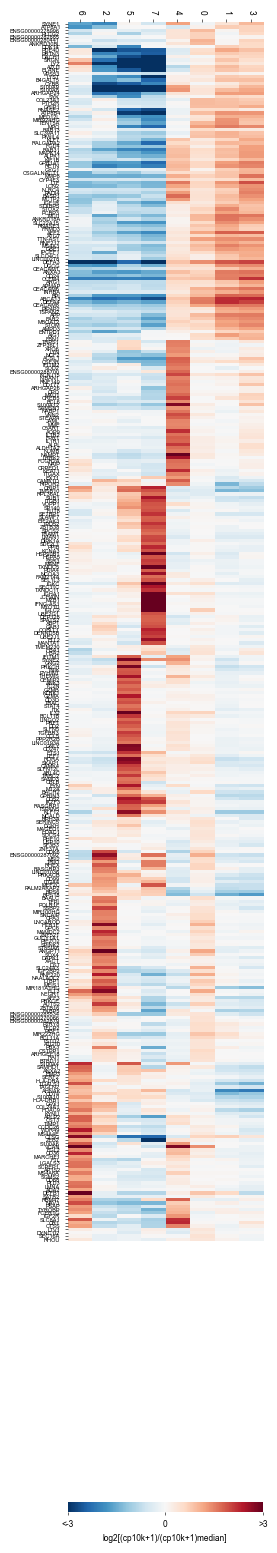

In [62]:
#a,fig,gs = rz.startfig(1+heat.shape[1]/3.,4+heat.shape[0]/40.,frameon=False)
a,fig,gs = rz.startfig(7,45,frameon=False)




cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-3
vmax=3
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
#rz.yticks_fancy(a,totick,labels_all = heat.index)

a.set_yticks(np.arange(heat.shape[0]))
a.set_yticklabels(heat.index,fontsize=4)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
fname = 'AML_heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=600)
plt.savefig(outdir+'%s.png'%fname,dpi=600)

outputs/AML_prec_only_dendrogram_louvain_resolution_0.5_250127_10h07.pdf


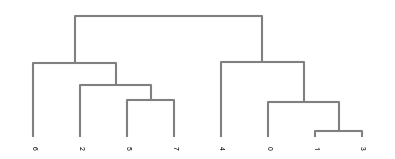

In [65]:
a,fig,gs = rz.startfig(10,4)
col_link = hierdict['col_link']
dendro = scipy.cluster.hierarchy.dendrogram(
                                 col_link, orientation='top', ax=a,
                                 above_threshold_color='0.5',
                                 color_threshold = 0,
                                    )

a.set_xticklabels(heat2.columns,rotation=270,fontsize=5)
a.set_yticks([])

rz.showspines(a)

gs.tight_layout(fig)
fname = str(outdir) + 'AML_prec_only_dendrogram_%s_%s.pdf'%(thelabel,rz.now())
print(fname)
plt.savefig(fname)